In [1]:
import torch
from torch import nn
#https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)    
    
train_set = torchvision.datasets.MNIST(
    root="./", train=True, download=True, transform=transform
)

In [2]:
print(device)

cuda


In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

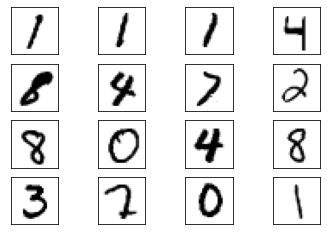

In [4]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(4704, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(200, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [17]:
lr = 0.0001
num_epochs = 200
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [18]:
for epoch in range(num_epochs):
    
    torch.save(discriminator.state_dict(), './models/dis' + str(epoch))
    torch.save(generator.state_dict(), './models/gen' + str(epoch))
    
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 200)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        optimizer_discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 200)).to(
            device=device
        )

        # Training the generator
        optimizer_generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
    #torch.save(discriminator.state_dict(), './models/dis' + str(epoch))
    #torch.save(generator.state_dict(), './models/gen' + str(epoch))

Epoch: 0 Loss D.: 0.2805224657058716
Epoch: 0 Loss G.: 2.104022741317749
Epoch: 1 Loss D.: 0.4349049925804138
Epoch: 1 Loss G.: 1.9602470397949219
Epoch: 2 Loss D.: 0.2184162437915802
Epoch: 2 Loss G.: 2.063304901123047
Epoch: 3 Loss D.: 0.37621188163757324
Epoch: 3 Loss G.: 2.1235384941101074
Epoch: 4 Loss D.: 0.28772127628326416
Epoch: 4 Loss G.: 2.178394317626953
Epoch: 5 Loss D.: 0.38943713903427124
Epoch: 5 Loss G.: 2.383617877960205
Epoch: 6 Loss D.: 0.250499427318573
Epoch: 6 Loss G.: 2.138209104537964
Epoch: 7 Loss D.: 0.34497249126434326
Epoch: 7 Loss G.: 1.8285531997680664
Epoch: 8 Loss D.: 0.26547330617904663
Epoch: 8 Loss G.: 1.9224226474761963
Epoch: 9 Loss D.: 0.2549165189266205
Epoch: 9 Loss G.: 1.8012531995773315
Epoch: 10 Loss D.: 0.30026599764823914
Epoch: 10 Loss G.: 2.043663263320923
Epoch: 11 Loss D.: 0.42430105805397034
Epoch: 11 Loss G.: 1.8975452184677124
Epoch: 12 Loss D.: 0.3226885199546814
Epoch: 12 Loss G.: 1.8672797679901123
Epoch: 13 Loss D.: 0.27713006734

Epoch: 108 Loss D.: 0.08705715835094452
Epoch: 108 Loss G.: 2.709054946899414
Epoch: 109 Loss D.: 0.20002314448356628
Epoch: 109 Loss G.: 3.158315896987915
Epoch: 110 Loss D.: 0.11228032410144806
Epoch: 110 Loss G.: 3.2319488525390625
Epoch: 111 Loss D.: 0.13810214400291443
Epoch: 111 Loss G.: 3.251270294189453
Epoch: 112 Loss D.: 0.06400135904550552
Epoch: 112 Loss G.: 2.9500231742858887
Epoch: 113 Loss D.: 0.14480340480804443
Epoch: 113 Loss G.: 3.4295308589935303
Epoch: 114 Loss D.: 0.13228560984134674
Epoch: 114 Loss G.: 2.5935049057006836
Epoch: 115 Loss D.: 0.19894981384277344
Epoch: 115 Loss G.: 3.145240306854248
Epoch: 116 Loss D.: 0.05875478312373161
Epoch: 116 Loss G.: 3.242461919784546
Epoch: 117 Loss D.: 0.11998619884252548
Epoch: 117 Loss G.: 2.7011027336120605
Epoch: 118 Loss D.: 0.07559619843959808
Epoch: 118 Loss G.: 2.9568257331848145
Epoch: 119 Loss D.: 0.16275696456432343
Epoch: 119 Loss G.: 3.3618359565734863
Epoch: 120 Loss D.: 0.2156916856765747
Epoch: 120 Loss G.

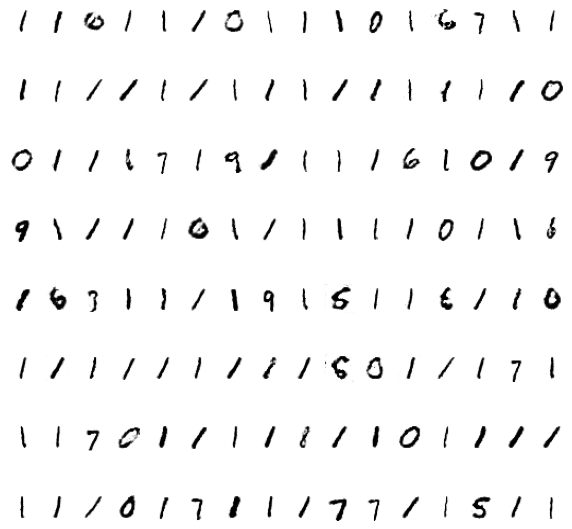

In [25]:
test_model = Generator().to(device=device)
test_model.load_state_dict(torch.load('./models/gen61'))
test_model.eval()

fig = plt.figure(figsize=(10, 10))
                 
# setting values to rows and column variables
num_of_batch = 4

rows = int((batch_size * num_of_batch) / 16)
columns = 16
                 
for c in range(num_of_batch):
        
    latent_space_samples = torch.randn((batch_size, 200)).to(device=device)
    generated_samples = test_model(latent_space_samples)
    generated_samples = generated_samples.cpu().detach().numpy()
        
    for i in range(batch_size):
        fig.add_subplot(rows, columns, (batch_size*c + i) + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.axis('off')

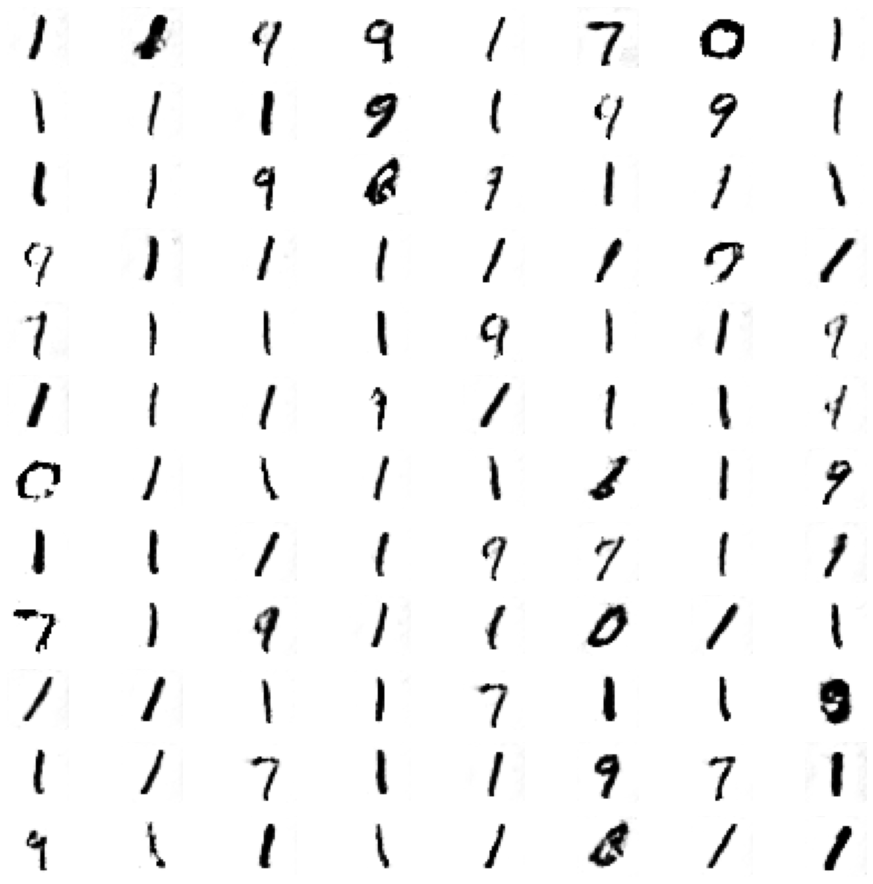

In [15]:
fig = plt.figure(figsize=(16, 16))
                 
# setting values to rows and column variables
rows = 12
columns = 8
                 
for c in range(3):
        
    latent_space_samples = torch.randn((batch_size, 200)).to(device=device)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.cpu().detach().numpy()
        
    for i in range(batch_size):
        fig.add_subplot(rows, columns, (32*c + i) + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.axis('off')